In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser
import sqlite3
import seaborn as sns

#### compare detected features for the three methods

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

FEATURES_MQ_DIR = '{}/features-mq'.format(EXPERIMENT_DIR)
FEATURES_MQ_FILE = '{}/exp-{}-run-{}-features-mq-dedup.pkl'.format(FEATURES_MQ_DIR, experiment_name, run_name)

In [3]:
MAXIMUM_Q_VALUE = 0.01

In [4]:
# only look at this part of the run
RT_LOWER = 1650
RT_UPPER = 2200

In [5]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

In [6]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_pasef_df = d['features_df']

In [7]:
features_pasef_df['excluded'] = features_pasef_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)

In [8]:
features_pasef_df = features_pasef_df[(features_pasef_df.excluded == False)]

In [9]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

In [10]:
# load the features detected by MaxQuant
with open(FEATURES_MQ_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_mq_df = d['features_df']

In [11]:
features_mq_df['excluded'] = features_mq_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_mq_df = features_mq_df[(features_mq_df.excluded == False)]
features_mq_df = features_mq_df[(features_mq_df.rt_apex >= RT_LOWER) & (features_mq_df.rt_apex <= RT_UPPER)]
features_mq_df = features_mq_df[(features_mq_df.isotope_count >= 3)].copy()

In [12]:
print('{} features from PASEF, {} features from MaxQuant, {} features from 3DID'.format(len(features_pasef_df), len(features_mq_df), len(features_3did_df)))


70406 features from PASEF, 15437 features from MaxQuant, 157961 features from 3DID


#### consolidate the features from all methods

In [13]:
features_mq_df = features_mq_df[['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']]
features_mq_df['method'] = 'mq'

features_pasef_df = features_pasef_df[['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']]
features_pasef_df['method'] = 'pasef'

features_3did_df = features_3did_df[['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']]
features_3did_df['method'] = '3did'

combined_df = pd.concat([features_mq_df,features_pasef_df,features_3did_df], axis=0, sort=False, ignore_index=True)
combined_df['method_feature_id'] = combined_df.method+'-'+combined_df.feature_id.astype('str')

In [14]:
combined_df.sample(n=3)

,feature_id,charge,monoisotopic_mz,scan_apex,rt_apex,method,method_feature_id
21869,2744501,2,939.459735,261.0,1945.778260,pasef,pasef-2744501
86946,368136,3,909.717439,405.0,2079.662549,3did,3did-368136
158232,337436,2,1004.997639,285.0,1695.431405,3did,3did-337436


#### find the features in common

In [15]:
DUP_MZ_TOLERANCE_PPM = 10
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 5

In [16]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_df['dup_mz'] = combined_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_df['dup_mz_ppm_tolerance'] = combined_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_df['dup_mz_lower'] = combined_df.dup_mz - combined_df.dup_mz_ppm_tolerance
combined_df['dup_mz_upper'] = combined_df.dup_mz + combined_df.dup_mz_ppm_tolerance
combined_df['dup_scan_lower'] = combined_df.scan_apex - DUP_SCAN_TOLERANCE
combined_df['dup_scan_upper'] = combined_df.scan_apex + DUP_SCAN_TOLERANCE
combined_df['dup_rt_lower'] = combined_df.rt_apex - DUP_RT_TOLERANCE
combined_df['dup_rt_upper'] = combined_df.rt_apex + DUP_RT_TOLERANCE

In [21]:
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_df[(row.charge == combined_df.charge) & (row.dup_mz >= combined_df.dup_mz_lower) & (row.dup_mz <= combined_df.dup_mz_upper) & (row.scan_apex >= combined_df.dup_scan_lower) & (row.scan_apex <= combined_df.dup_scan_upper) & (row.rt_apex >= combined_df.dup_rt_lower) & (row.rt_apex <= combined_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            # form a hybrid feature_id from the method feature_ids
            hybrid_feature_id = '-'.join(sorted(set(df.method_feature_id.tolist())))
            for method in df.method.tolist():
                sets_d[method].add(hybrid_feature_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))

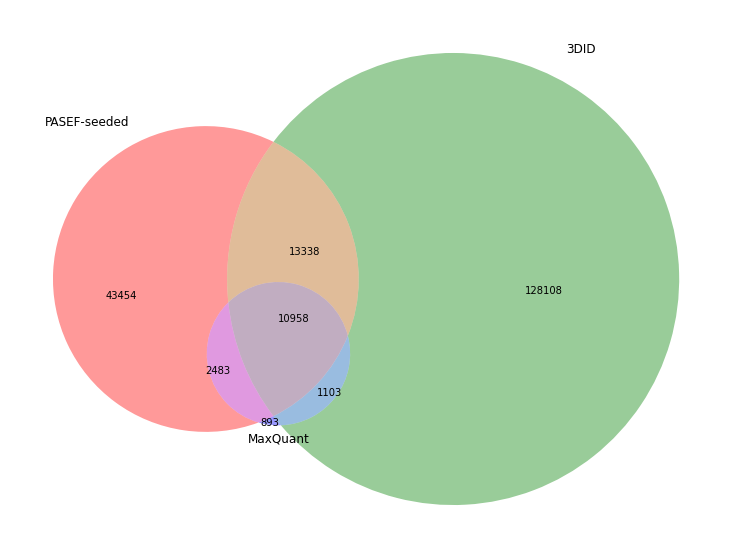

In [22]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()